In [17]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os
from sklearn.ensemble import RandomForestClassifier



In [18]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/197786
Connected. Call `.close()` to terminate connection gracefully.


In [19]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine_final", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine_final",
                                  version=1,
                                  description="Read from Wine Quality dataset",
                                  labels=["quality"],
                                  query=query)


In [20]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size=0.2)



Finished: Reading data from Hopsworks, using ArrowFlight (3.16s) 


In [21]:
# Initialize the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=1)  # You can adjust parameters here

# Train the classifier
model.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, random_state=1)

In [22]:
X_train

,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,density,alcohol
0,0.560000,0.190000,0.081000,108.0,0.996200,9.500000
1,0.620000,0.190000,0.170000,148.0,0.998600,9.200000
2,0.220000,0.360000,0.056000,153.0,0.993000,10.400000
3,0.200000,0.170000,0.048000,129.0,0.991000,11.400000
4,0.460000,0.180000,0.034000,98.0,0.989600,12.600000
...,...,...,...,...,...,...
19413,0.360000,0.460000,0.054950,83.0,0.995600,10.100000
19415,0.580648,0.260000,0.039000,143.0,0.994200,9.800000
19417,0.636896,0.426417,0.076372,171.0,0.996298,9.107483
19418,0.303418,0.197568,0.035878,68.0,0.990427,11.387630


In [23]:
y_train

,quality
0,0
1,0
2,1
3,1
4,1
...,...
19413,0
19415,0
19417,0
19418,1


In [24]:
X_test

,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,density,alcohol
13,0.270000,0.490000,0.063000,92.0,0.991100,12.200000
24,0.430000,0.340000,0.080000,86.0,0.998700,9.500000
25,0.320000,0.430000,0.050000,65.0,0.993460,10.700000
31,0.280000,0.300000,0.030000,115.0,0.991920,12.300000
33,0.280000,0.350000,0.028000,91.0,0.990220,12.100000
...,...,...,...,...,...,...
19406,0.240000,0.065463,0.049000,217.0,0.998500,8.800000
19410,0.242517,0.360000,0.044000,68.0,0.990140,11.700000
19414,0.272030,0.290000,0.046000,227.0,0.995200,10.100000
19416,0.263537,0.328022,0.041039,68.0,0.990194,11.664469


In [25]:
# Predict labels for the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1954
           1       0.92      0.87      0.89      1931

    accuracy                           0.90      3885
   macro avg       0.90      0.90      0.90      3885
weighted avg       0.90      0.90      0.90      3885



In [26]:
# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred,output_dict=True)
results = confusion_matrix(y_test, y_pred)

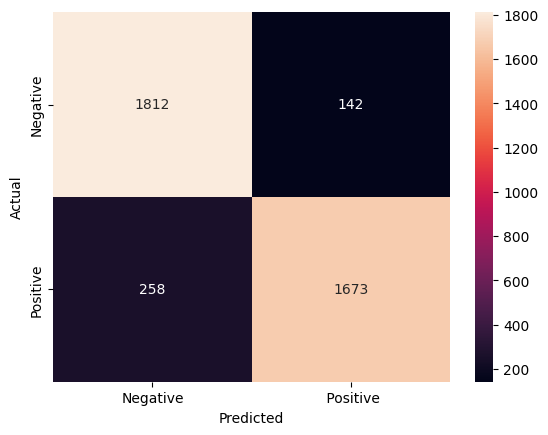

In [27]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results,["Negative", "Positive"],["Negative"," Positive"])
cm = sns.heatmap(df_cm, annot=True, fmt='d')
cm.set_xlabel('Predicted')
cm.set_ylabel('Actual')

fig = cm.get_figure()

In [28]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
iris_model = mr.python.create_model(
    name="wine_model_final", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
iris_model.save(model_dir)


Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/197786/models/wine_model_final/3


Model(name: 'wine_model_final', version: 3)